In [1]:
# Load libraries and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
RANDOM_STATE = 42  # Pseudo-random state

from utils import *
sns.set_palette("tab10") # Default seaborn theme

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Upload updated data

#### Columns that are used for clinical diagnosis of HARTI - we don't use them:
cols_dx = ['tbd_sanation', 'fio2', 'purulent_sputum', 'xray_inf', 'pleural_drain', 'temperature']

In [2]:
# Upload dataset
fn_vae_data = glob.glob('./data/Updated*.pkl')
latest_fn_vae_data = max(fn_vae_data, key=os.path.getctime)

print("Loading... ",latest_fn_vae_data)
with open(latest_fn_vae_data, "rb") as f:
    vae_data_main = pickle.load(f)
print("Done")


Loading...  ./data/Updated_VAE_Data_Main_0821_0932.pkl
Done


# Population dynamics in time
[Stationarity](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)
[ADF Test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [3]:
# Select patient characteristics and interventions with possible changes over time

FACTORS = ('age', 'gender_M', 'disease_type_trauma', 'disease_type_tumor', # condition on admission
           'disease_type_vascular', 'disease_type_other', 'charlson',
           
           'st_device_count', 'st_endonasal_count', 'st_endovascular_count',  # surgical practice
           'st_other_count', 'st_spinal_count', 'st_craniotomy_count',
           'st_device_len', 'st_other_len', 'st_craniotomy_len', 'st_endovascular_len',
           'st_endonasal_len', 'st_spinal_len',
           
           'consciousness', 'pbss', 'aphasia', 'rass', # severity of patients condition
           
           'mech_vent',   'antibiotics_total_binary', 'central_line', 'feeding_tube', # ICU standard of care
           'arterial_line', 'evd', 'icpm', 'urinary_catheter', 'hypothermia', 'hemodialysis',
           'total_parenteral_feeding', 'sedation', 'anxiolytics',  'vasopressors',
           'days_mech_vent_before_tracheostomy', 'days_before_tracheostomy',
           
           'infection_cns', 'infection_urinary', 'infection_bloodstream', 'infection_ssi',
           'infection_other', 'intestinal_dysfunction', 'outcome_death',
           
           'los', 'day_in_icu_max',
          )

# Columns to add 
for col in [col for col in FACTORS if 'st_' in col and '_len' in col]:  # st_*_len columns
    vae_data_main.loc[:,col + '_mean'] = vae_data_main.loc[:,col].apply(lambda x: np.nanmean(x) if isinstance(x, list) else x)
    
# now let's replace columns st_*_len with st_*_len_mean in FACTORS
FACTORS = [col + '_mean' if 'st_' in col and '_len' in col else col for col in FACTORS]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [4]:
##### Adfuller tests to check stationarity: If we fail to reject the null hypothesis (p-value >0.05),
##### we can say that the series is non-stationary.

# Define function to calculate timeseries statistics
def get_yy_by_col(dataframe, yy_col='gender_M', date_col='yearmonth', abs_values='ratio',
                  inner_agg_func='max', uid='ID_subid', return_by=None):
    assert date_col in ['yearmonth', 'year', 'date', 'halfyear']
    assert return_by != 'year' or date_col == 'date', 'Return by year only works with date'
    
    ID_subid_first_date = dataframe[[uid, date_col]].groupby(uid).min()

    if inner_agg_func in 'sum' and abs_values == 'median':
        mask = (dataframe[[uid, yy_col]].groupby(uid).agg(inner_agg_func) > 0)
        a = dataframe[[uid, yy_col]].groupby(uid).agg(inner_agg_func).join(ID_subid_first_date)[mask.values].groupby(date_col)
    else:  # default behaviour
        a = dataframe[[uid, yy_col]].groupby(uid).agg(inner_agg_func).join(ID_subid_first_date).groupby(date_col)
    
    res_sum = None
    if abs_values == 'ratio':
        res = a.sum() / a.count()
        res_sum = a.sum()
    elif abs_values in ['count', 'sum', 'mean', 'median']:
        res = a.agg(abs_values)
    elif abs_values == 'meanwithoutzeros':
        res = a.agg(lambda x: x.replace(0., np.nan).agg(np.nanmean))  # чтобы не учитывались в средней длительности операции значения 0
    else:
        raise ValueError
        
    # 'rass', 'pbss', etc.
    if date_col == 'date' and return_by == 'year':
        res = res.groupby(res.index.year).agg(['mean', 'std'])
        res.columns = [yy_col, yy_col + '_ci']
        return res
    elif date_col == 'date' and return_by == 'month':
        return res.groupby(res.index.strftime('%y%m')).mean()[yy_col]
    elif date_col == 'date' and return_by == 'overall':
        res = res.agg(['mean', 'std'])
        return res
    
    if inner_agg_func == 'sum' and abs_values == 'median':
        if date_col == 'date':
            percentiles_25_75 = a.sum().describe().T.iloc[:,[4,6]]
            percentiles_25_75.index = [0]
        else:
            percentiles_25_75 = a.describe().iloc[:,[4,6]]
        
        cil = percentiles_25_75.iloc[:,[0]]
        cir = percentiles_25_75.iloc[:,[1]]
    
    elif inner_agg_func == 'max' and abs_values == 'median':  # los, day in icu
        assert yy_col in ('los', 'day_in_icu_max')
        if date_col == 'date':
            percentiles_25_75 = a.median().describe().T.iloc[:,[4,6]]
            percentiles_25_75.index = [0]
        else:
            percentiles_25_75 = a.describe().iloc[:,[4,6]]
        cil = percentiles_25_75.iloc[:,[0]]
        cir = percentiles_25_75.iloc[:,[1]]
        
    elif date_col == 'date':
        cil, cir = ci(a.sum().sum(), a.count().sum())
        cil, cir = pd.DataFrame(cil).T, pd.DataFrame(cir).T

    else:
        cil, cir = ci(a.sum(), a.count())
    
    if cir.isnull().all().any() or cil.isnull().all().any():
        if date_col == 'date':
            cil, cir = pd.DataFrame(a.max().std()).T, pd.DataFrame(a.max().std()).T
        else:
            cil, cir = a.std(), a.std()
        
    cil.columns = ['cil']
    cir.columns = ['cir']
    
    vals = [f"{l:.3f}; {r:.3f}" for l, r in zip(cil['cil'], cir['cir'])]
    cols = cil.index.astype('str') + '_ci'
    res_ci = pd.DataFrame(vals, index=cols, columns=[yy_col])

    if date_col == 'date' and inner_agg_func == 'sum' and abs_values == 'median':
        result_dict = {yy_col: pd.DataFrame(np.median(res.values), columns=[yy_col], index=['overall']), yy_col + '_ci': res_ci}
    elif date_col == 'date' and inner_agg_func == 'max' and abs_values == 'median':
        # day_in_icu_max, los        
        result_dict = {yy_col: pd.DataFrame(res.median().values, columns=[yy_col], index=['overall']), yy_col + '_ci': res_ci}
        
    elif date_col == 'date':
        result_dict = {yy_col: pd.DataFrame(res.mean().values, columns=[yy_col], index=['overall']), yy_col + '_ci': res_ci}
    else:
        result_dict = {yy_col: res, yy_col + '_ci': res_ci}
        
    if abs_values == 'ratio':
        res_sum.index = res_sum.index.astype('str') + '_count'
        result_dict[yy_col + '_count'] = res_sum        

    return result_dict

In [7]:
# Assess dynamics in factors using both linreg and Adfuller tests; monthly data;
# Date for each patient is attributed to the month of admission

table = {}
for col in FACTORS:
    UID = 'ID_subid' if col != 'outcome_death' else 'ID'
    
    if col in ['rass', 'pbss', 'consciousness', 'charlson']:
        ts = get_yy_by_col(vae_data_main, yy_col=col, date_col='date', abs_values='mean', return_by='month', uid=UID)
        pval = adfuller(ts.values.reshape(-1))[1]
        a = linregress(ts.values.reshape(-1), np.arange(len(ts.values.reshape(-1)))).pvalue
        
        ts2 = get_yy_by_col(vae_data_main, yy_col=col, date_col='date', abs_values='mean', return_by='year', uid=UID)
        # ts2_ci
        ts2_ci = ts2[[col + '_ci']]
        index_ci = ts2[col + '_ci'].index.astype('str') + '_ci'
        ts2_ci.index = index_ci
        ts2_ci.columns = [col]
        ts2 = ts2[[col]]
        #ts2.index = ts2.index.astype('str')
        
        ts3 = get_yy_by_col(vae_data_main, yy_col=col, date_col='date', abs_values='mean', return_by='overall', uid=UID)
        ts3_mean = ts3.values[0]
        ts3_std = ts3.values[1]
        ts3 = pd.DataFrame(ts3_mean, index=[col], columns=['overall']).T
        ts3_ci = pd.DataFrame(ts3_std, index=[col], columns=['0_ci']).T        
        
        table[col] = pd.concat([ts2, ts2_ci, ts3, ts3_ci]).to_dict()[col]
        table[col]['adfuller_pvalue'] = np.round(pval, 5)
        table[col]['linreg'] = np.round(a, 5)

        
    else:
        if col == 'ID_subid':
            abs_value_flag = 'count'
        elif 'st_' in col and '_len_mean' in col:
            abs_value_flag = 'meanwithoutzeros'
        elif col in ['day_in_icu_max', 'los']:
            abs_value_flag = 'median'
        else:
            abs_value_flag = 'ratio'    

        ts = get_yy_by_col(vae_data_main, yy_col=col, date_col='yearmonth', abs_values=abs_value_flag, uid=UID)[col]

        if ts.isna().max()[0]:  # if Nan 
            ts = ts.fillna(method='ffill').fillna(method='bfill')

        pval = adfuller(ts.values.reshape(-1))[1]
        a = linregress(ts.values.reshape(-1), np.arange(len(ts.values.reshape(-1)))).pvalue

        ts2: dict = get_yy_by_col(vae_data_main, yy_col=col, date_col='year', abs_values=abs_value_flag, uid=UID)
        if abs_value_flag == 'ratio':
            ts2_count = ts2[col + '_count']
        
        ts2, ts2_ci = ts2[col], ts2[col + '_ci']  # '2011, 2012, ...'
        

        ts3 = get_yy_by_col(vae_data_main, yy_col=col, date_col='date', abs_values=abs_value_flag, uid=UID)
        ts3, ts3_ci = ts3[col], ts3[col + '_ci']  # 'Overall' column

        to_concat = [ts2, ts2_ci, ts3, ts3_ci]
        if abs_value_flag == 'ratio':
            to_concat += [ts2_count]
        
        table[col] = pd.concat(to_concat).to_dict()[col]
        table[col]['adfuller_pvalue'] = np.round(pval, 5)
        table[col]['linreg'] = np.round(a, 5)
tabley = pd.DataFrame.from_dict(table).T

/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(q_ * (1 - q_) / nobs)
/usr/local/lib/p

In [8]:
# Median length of ICU standard of care factors in days; monthly data

# ICU standard of care
ICU_standard_of_care = ['mech_vent', 'antibiotics_total_binary', 'central_line', 'feeding_tube',
                        'arterial_line', 'evd', 'icpm', 'urinary_catheter', 'hypothermia', 'hemodialysis',
                        'total_parenteral_feeding', 'sedation', 'anxiolytics',  'vasopressors']
tablex = {}
for col in ICU_standard_of_care:
    inner_agg_func = 'sum'
    abs_value_flag = 'median'
    ts = get_yy_by_col(vae_data_main, yy_col=col, date_col='yearmonth', abs_values=abs_value_flag,
                       inner_agg_func=inner_agg_func,)[col]
    pval = adfuller(ts.values.reshape(-1))[1]
    linreg = linregress(ts.values.reshape(-1), np.arange(len(ts.values.reshape(-1)))).pvalue
        
    ts2 = get_yy_by_col(vae_data_main, yy_col=col, date_col='year', abs_values=abs_value_flag,
                        inner_agg_func=inner_agg_func,)
    ts2, ts2_ci = ts2[col], ts2[col + '_ci']  # '2011, 2012, ...'
    
    ts3 = get_yy_by_col(vae_data_main, yy_col=col, date_col='date', abs_values=abs_value_flag,
                        inner_agg_func=inner_agg_func)
    ts3, ts3_ci = ts3[col], ts3[col + '_ci']  # 'Overall' column

    tablex[col] = pd.concat([ts2, ts2_ci, ts3, ts3_ci]).to_dict()[col]
    tablex[col]['adfuller_pvalue'] = np.round(pval, 5)
    tablex[col]['linreg'] = np.round(linreg, 5)
tablex = pd.DataFrame.from_dict(tablex).T
tablex.index = [str(col) + '_median' for col in tablex.index]

In [11]:
# Combine data from two calculations in one table
table_1 = pd.concat([tabley, tablex], axis=0, sort=True)
# multiple comparisons adjustment in linreg p-value
table_1['adj_linreg'] = multitest.multipletests(table_1.linreg, alpha=0.05, method='holm')[1]
table_1
table_1.to_csv('./table_1.csv', sep='\t', encoding='utf-8')

____

# Daily prevalence of all HARTI

In [12]:
# Define function

def plot_regression_line(ts_infections, ts_total_people, a, b, c):
    data = pd.DataFrame(ts_infections * a/ ts_total_people).reset_index()
    data.columns = ['date', 'value']
    # Fit a polyfit model
    x = np.arange(data['date'].size) 
    slope, intercept = np.polyfit(x, data['value'], 1)
    fit = np.polyfit(x, data['value'], 1) # first degree polynomial
    fit_fn = np.poly1d(fit)
    # Plot scatter plot and regression model
    plt.figure(figsize=(15,6))
    plt.plot(data['date'], data['value'], 'bo', ms=2, marker='x')
    plt.plot(data['date'], data['value'].rolling(window=30, center=True).mean())
    plt.plot(data['date'], fit_fn(x), 'k-')
    fit = np.polyfit(x, data['value'], 9) # 9th degree polynomial
    fit_fn = np.poly1d(fit)
    plt.plot(data['date'], fit_fn(x), 'k-', color='green')
    # Add data decomposition to find a trend
    ts_ratio = (ts_infections / ts_total_people)
    decomposition = sm.tsa.seasonal_decompose(pd.DataFrame(ts_ratio), freq=365, model='additive')
    plt.plot(decomposition.trend*a, color='red')
    plt.grid(linestyle='dotted')
    plt.xlabel('Years')
    plt.ylim(b, c)
    print('Slope (change per day): ', slope)
    print('Slope (change per year): ', slope*365)
    print('Slope (change per study period): ', slope*365*8)
    plt.legend(('one day value', 'smoothed monthly average', 'fitted linear model', '9th-degree polynomial', 'annual trend'),
               fontsize=12, loc='upper right')
    
def get_data_for_regression(ts_infections, ts_total_people, a):
    data = pd.DataFrame(ts_infections * a/ ts_total_people).reset_index()
    data.columns = ['date', 'value']

    x = np.arange(data['date'].size) 
    return x, data['value']

Slope (change per day):  -0.003877043562937957
Slope (change per year):  -1.4151209004723542
Slope (change per study period):  -11.320967203778833


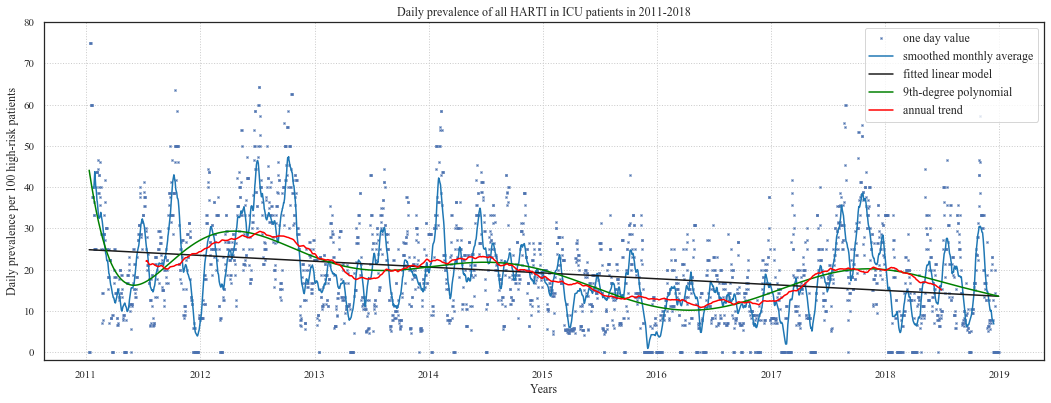

In [13]:
# Plot prevalence of all HARTI
ts_infections = vae_data_main.groupby('date').sum()['infection_respiratory']
ts_total_people = vae_data_main.groupby('date').count()['ID']
ts_ratio = (ts_infections / ts_total_people)

plot_regression_line(ts_infections, ts_total_people, 100, -2, 80)
plt.ylabel('Daily prevalence per 100 high-risk patients')
plt.title('Daily prevalence of all HARTI in ICU patients in 2011-2018')
plt.tight_layout()
plt.savefig('./pictures/prevalence_all.pdf', dpi=600)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     211.8
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           2.28e-46
Time:                        09:42:12   Log-Likelihood:                 2025.2
No. Observations:                2909   AIC:                            -4046.
Df Residuals:                    2907   BIC:                            -4034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8290      0.044     18.905      0.0

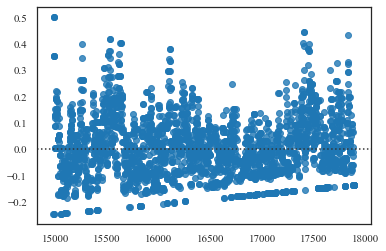

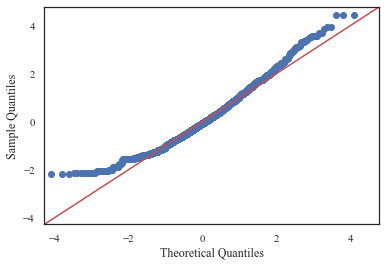

In [14]:
# Linear regression model

# Define data
a = pd.DataFrame(ts_ratio)
a1 = a.index.values.astype('datetime64[D]')
x = a1.astype('int')
x = sm.add_constant(x)
y = a[0].values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

###### Check the quality of linear model
# Plot residuals
x = a1.astype('int')
sns.residplot(x, y)
###### Seemingly uniformal distribution of residuals -> can use linear model ######

# Plot QQ plot
res = results.resid # residuals
sm.qqplot(res, stats.t, fit=True, line='45')
##### Lightly tailed QQ plot -> can use linear model ######

# Get goodness-of-fit for polynomial regression
x = sm.add_constant(x)
polynomial_features= PolynomialFeatures(degree=9)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
#model.summary()
print('\nR squared for 9th-degree polynomial: ', model.rsquared)

In [15]:
# print results
ts_ratio_2011 = ts_ratio[((ts_ratio.index >= '2011') & (ts_ratio.index < '2012'))]
ts_ratio_2018 = ts_ratio[((ts_ratio.index >= '2018') & (ts_ratio.index < '2019'))]

print('Mean prevalence: ', ts_ratio.mean())
print('Mean prevalence 2011: ', ts_ratio_2011.mean())
print('Mean prevalence 2018: ', ts_ratio_2018.mean())
print('Lowest prevalence, 2016: ', ts_ratio[((ts_ratio.index >= '2016') & (ts_ratio.index < '2017'))].mean())
print('Highest prevalence, 2012: ', ts_ratio[((ts_ratio.index >= '2012') & (ts_ratio.index < '2013'))].mean())

# Welch’s t-test, which does not assume equal population variance
print('Welch ttest p-value: ', ttest_ind(ts_ratio_2011, ts_ratio_2018, equal_var=False)[1])

Mean prevalence:  0.1916493444408161
Mean prevalence 2011:  0.22417738672273646
Mean prevalence 2018:  0.149388101576131
Lowest prevalence, 2016:  0.12167468264731393
Highest prevalence, 2012:  0.2888971912451844
Welch ttest p-value:  5.743512067452449e-14


### Prevalence of VA-HARTI

Slope (change per day):  -0.003704726526660707
Slope (change per year):  -1.352225182231158
Slope (change per study period):  -10.817801457849264


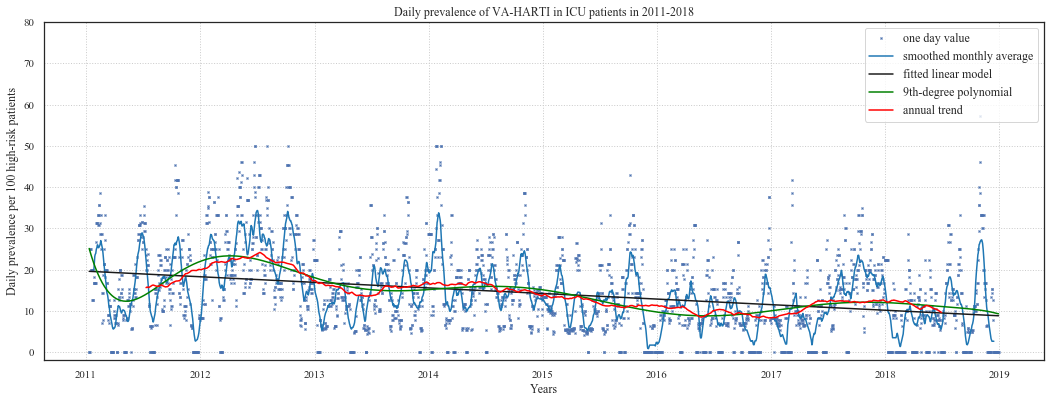

In [16]:
# Plot prevalence of VA-HARTI
ts_infections = vae_data_main.groupby('date').sum()['vap']
ts_total_people = vae_data_main.groupby('date').count()['ID']
ts_ratio = (ts_infections / ts_total_people)

plot_regression_line(ts_infections, ts_total_people, 100, -2, 80)
plt.ylabel('Daily prevalence per 100 high-risk patients')
plt.title('Daily prevalence of VA-HARTI in ICU patients in 2011-2018')
plt.tight_layout()
plt.savefig('./pictures/prevalence_vap.pdf', dpi=600)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     295.0
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           4.62e-63
Time:                        09:42:19   Log-Likelihood:                 2639.6
No. Observations:                2909   AIC:                            -5275.
Df Residuals:                    2907   BIC:                            -5263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7508      0.036     21.149      0.0

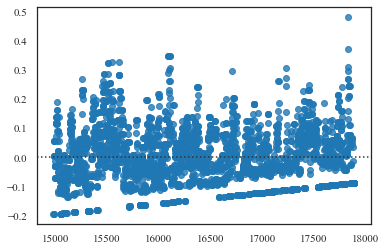

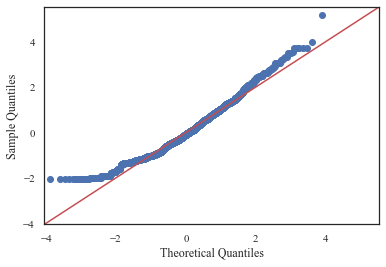

In [17]:
# Linear regression model

# Define data
a = pd.DataFrame(ts_ratio)
a1 = a.index.values.astype('datetime64[D]')
x = a1.astype('int')
x = sm.add_constant(x)
y = a[0].values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

###### Check the quality of linear model
# Plot residuals
x = a1.astype('int')
sns.residplot(x, y)
###### Seemingly uniformal distribution of residuals -> can use linear model ######

# Plot QQ plot
res = results.resid # residuals
sm.qqplot(res, stats.t, fit=True, line='45')
##### Lightly tailed QQ plot -> can use linear model ######

# Get goodness-of-fit for polynomial regression
x = sm.add_constant(x)
polynomial_features= PolynomialFeatures(degree=9)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
#model.summary()
print('\nR squared for 9th-degree polynomial: ', model.rsquared)

In [18]:
# print results
ts_ratio_2011 = ts_ratio[((ts_ratio.index >= '2011') & (ts_ratio.index < '2012'))]
ts_ratio_2018 = ts_ratio[((ts_ratio.index >= '2018') & (ts_ratio.index < '2019'))]

print('Mean prevalence: ', ts_ratio.mean())
print('Mean prevalence 2011: ', ts_ratio_2011.mean())
print('Mean prevalence 2018: ', ts_ratio_2018.mean())
print('Lowest prevalence, 2016: ', ts_ratio[((ts_ratio.index >= '2016') & (ts_ratio.index < '2017'))].mean())
print('Highest prevalence, 2012: ', ts_ratio[((ts_ratio.index >= '2012') & (ts_ratio.index < '2013'))].mean())

# Welch’s t-test, which does not assume equal population variance
print('Welch ttest p-value: ', ttest_ind(ts_ratio_2011, ts_ratio_2018, equal_var=False)[1])

Mean prevalence:  0.1418093954451207
Mean prevalence 2011:  0.158084722222646
Mean prevalence 2018:  0.09546579857898549
Lowest prevalence, 2016:  0.10034822442196956
Highest prevalence, 2012:  0.23794136745654312
Welch ttest p-value:  7.707874863514768e-16


### Prevalence of NVA-HARTI

Slope (change per day):  -0.0001723170362772467
Slope (change per year):  -0.06289571824119505
Slope (change per study period):  -0.5031657459295604


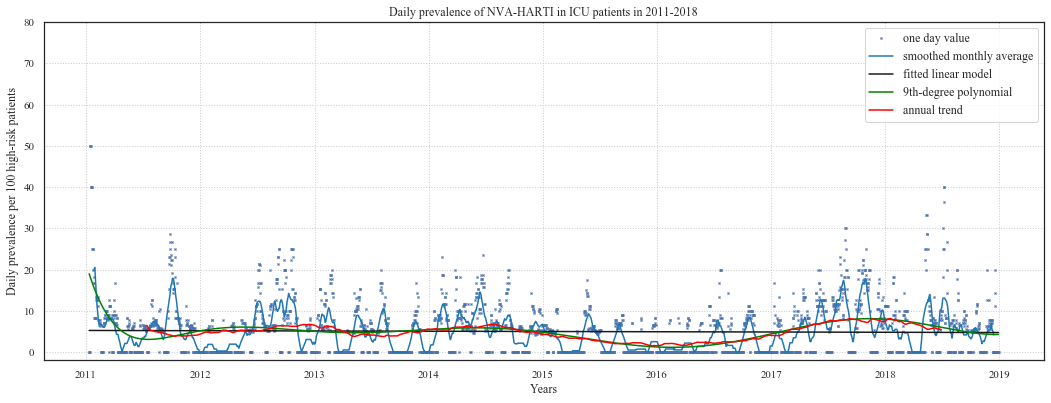

In [19]:
# Plot prevalence of VA-HARTI
ts_infections = vae_data_main.groupby('date').sum()['non_vap_resp_hai']
ts_total_people = vae_data_main.groupby('date').count()['ID']
ts_ratio = (ts_infections / ts_total_people)

plot_regression_line(ts_infections, ts_total_people, 100, -2, 80)
plt.ylabel('Daily prevalence per 100 high-risk patients')
plt.title('Daily prevalence of NVA-HARTI in ICU patients in 2011-2018')
plt.tight_layout()
plt.savefig('./pictures/prevalence_nva.pdf', dpi=600)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.508
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.220
Time:                        09:42:24   Log-Likelihood:                 3889.9
No. Observations:                2909   AIC:                            -7776.
Df Residuals:                    2907   BIC:                            -7764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0782      0.023      3.384      0.0

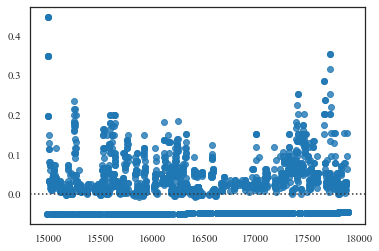

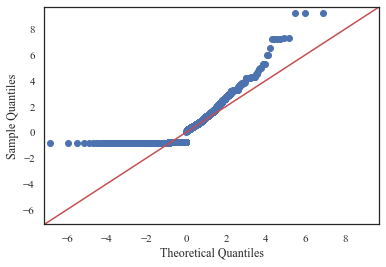

In [20]:
# Linear regression model

# Define data
a = pd.DataFrame(ts_ratio)
a1 = a.index.values.astype('datetime64[D]')
x = a1.astype('int')
x = sm.add_constant(x)
y = a[0].values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

###### Check the quality of linear model
# Plot residuals
x = a1.astype('int')
sns.residplot(x, y)
###### Non-uniformal distribution of residuals -> can't use linear model!!! ######

# Plot QQ plot
res = results.resid # residuals
sm.qqplot(res, stats.t, fit=True, line='45')
##### Disturbed QQ plot suggests right-skewed distribution-> can't use linear model!!! ######

# Get goodness-of-fit for polynomial regression
x = sm.add_constant(x)
polynomial_features= PolynomialFeatures(degree=9)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
#model.summary()
print('\nR squared for 9th-degree polynomial: ', model.rsquared)

In [21]:
# print results
ts_ratio_2011 = ts_ratio[((ts_ratio.index >= '2011') & (ts_ratio.index < '2012'))]
ts_ratio_2018 = ts_ratio[((ts_ratio.index >= '2018') & (ts_ratio.index < '2019'))]

print('Mean prevalence: ', ts_ratio.mean())
print('Mean prevalence 2011: ', ts_ratio_2011.mean())
print('Mean prevalence 2018: ', ts_ratio_2018.mean())
print('Lowest prevalence, 2016: ', ts_ratio[((ts_ratio.index >= '2016') & (ts_ratio.index < '2017'))].mean())
print('Highest prevalence, 2017: ', ts_ratio[((ts_ratio.index >= '2017') & (ts_ratio.index < '2018'))].mean())

# Welch’s t-test, which does not assume equal population variance
print('Welch ttest p-value: ', ttest_ind(ts_ratio_2011, ts_ratio_2018, equal_var=False)[1])

Mean prevalence:  0.04983994899569542
Mean prevalence 2011:  0.06609266450009044
Mean prevalence 2018:  0.05392230299714524
Lowest prevalence, 2016:  0.021326458225344163
Highest prevalence, 2017:  0.0747514751178567
Welch ttest p-value:  0.034355207109318074


### Days without HARTI per year

In [22]:
# days without infections per year
datetime_series = pd.to_datetime(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
                                  '2016-01-01', '2017-01-01', '2018-01-01'])
noinf = []
for i in datetime_series:
    a = (ts_ratio[((ts_ratio.index >= i) & (ts_ratio.index < i + datetime.timedelta(days=(365))))] ==0).sum()
    noinf.append(a)
noinf = pd.Series(noinf, index=datetime_series)
noinf

2011-01-01    132
2012-01-01    180
2013-01-01    203
2014-01-01    114
2015-01-01    225
2016-01-01    274
2017-01-01    144
2018-01-01    181
dtype: int64

# Cumulative proportional incidence of HARTI

In [23]:
# Overall cumulative incidence

ir = vae_data_main[['ID_subid', 'infection_respiratory']].groupby('ID_subid').max().sum()
cases = vae_data_main[['ID_subid']].groupby('ID_subid').max().shape[0]
print('Overall incidence all HARTI: ', (ir/cases).values)
print('\n95% CI all HARTI: ', ci(ir, cases)[0].values, ci(ir, cases)[1].values)

vap = vae_data_main[['ID_subid', 'vap']].groupby('ID_subid').max().sum()
print('\nOverall incidence VA-HARTI: ', (vap/cases).values)
print('\n95% CI, VA-HARTI: ', ci(vap, cases)[0].values, ci(vap, cases)[1].values)

nonvap = vae_data_main[['ID_subid', 'non_vap_resp_hai']].groupby('ID_subid').max().sum()
print('\nOverall incidence NVA-HARTI: ', (nonvap/cases).values)
print('\n95% CI NVA-HARTI: ', ci(nonvap, cases)[0].values, ci(nonvap, cases)[1].values)

Overall incidence all HARTI:  [0.22759554]

95% CI all HARTI:  [0.21248337] [0.2427077]

Overall incidence VA-HARTI:  [0.16097396]

95% CI, VA-HARTI:  [0.14772786] [0.17422006]

Overall incidence NVA-HARTI:  [0.07304701]

95% CI NVA-HARTI:  [0.06366809] [0.08242592]


All HARTI, Adfuller test:  0.014095693626964285
VA-HARTI, Adfuller test:  0.00013951497934633106
NVA-HARTI, Adfuller test:  0.15625205012199966


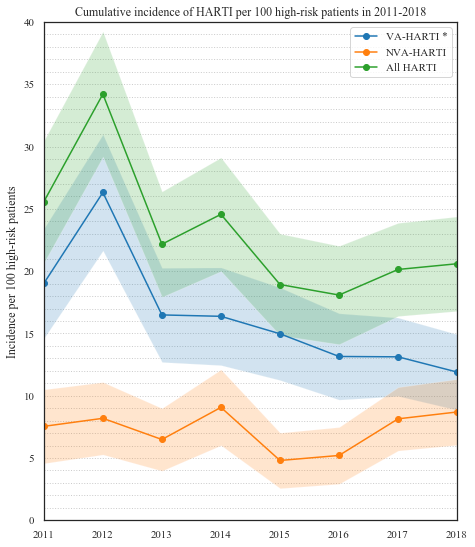

In [24]:
# Cumulative incidence by years
inc = {}
for col in ['vap', 'non_vap_resp_hai', 'infection_respiratory']:
    inc[col] = {}
    a = vae_data_main[['ID_subid', 'year', col]].groupby('ID_subid').max()
    x = a.groupby('year').sum()
    n = a.groupby('year').count()
    
    inc[col]['inc'] = (x / n).values.reshape(-1)
    inc[col]['ci_low'] = ci(x, n, alpha=0.05, method='normal')[0].values.reshape(-1)
    inc[col]['ci_up'] = ci(x, n, alpha=0.05, method='normal')[1].values.reshape(-1)

fig, ax = plt.subplots(1, figsize=(7,8))
for key, val in inc.items():
    val_df = pd.DataFrame(val) * 100
    val_df['inc'].plot(style='-o', linewidth=1.5, ax=ax)
    ax.fill_between(np.arange(val_df.shape[0]), val_df['ci_low'], val_df['ci_up'], alpha=.2)

xlabels = ('2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
plt.legend(labels = ['VA-HARTI *', 'NVA-HARTI', 'All HARTI'])
plt.title('Cumulative incidence of HARTI per 100 high-risk patients in 2011-2018')
plt.ylabel('Incidence per 100 high-risk patients')
plt.xlabel('')
ax.set_xticklabels(labels=xlabels)
plt.ylim(0, 40)
plt.minorticks_on()
plt.grid(linestyle='dotted', which='both', axis='y')
plt.tight_layout()
plt.savefig('pictures/incidence_years.pdf', bbox_inches="tight", dpi=600)

# Adfuller test for stationarity
print('All HARTI, Adfuller test: ', adfuller(inc['infection_respiratory']['inc'])[1])
print('VA-HARTI, Adfuller test: ', adfuller(inc['vap']['inc'])[1])
print('NVA-HARTI, Adfuller test: ', adfuller(inc['non_vap_resp_hai']['inc'])[1])

In [25]:
inc['vap']

{'inc': array([0.19016393, 0.26315789, 0.16486486, 0.16374269, 0.14971751,
        0.13150685, 0.13122172, 0.11899314]),
 'ci_low': array([0.14612257, 0.21648868, 0.12705635, 0.12452464, 0.11254993,
        0.09683643, 0.09974465, 0.0886362 ]),
 'ci_up': array([0.2342053 , 0.30982711, 0.20267338, 0.20296074, 0.1868851 ,
        0.16617726, 0.16269879, 0.14935007])}

### Test trends in incidence by linear regression

In [26]:
# Fit linear regression for all HARTI incidence
# Define data
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = sm.add_constant(x)
y = inc['infection_respiratory']['inc']

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     5.412
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0589
Time:                        09:42:40   Log-Likelihood:                 15.387
No. Observations:                   8   AIC:                            -26.77
Df Residuals:                       6   BIC:                            -26.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7524     12.690      2.345      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


In [27]:
# Fit linear regression for VA-HARTI incidence
# Define data
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = sm.add_constant(x)
y = inc['vap']['inc']

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     11.01
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0160
Time:                        09:42:42   Log-Likelihood:                 17.967
No. Observations:                   8   AIC:                            -31.93
Df Residuals:                       6   BIC:                            -31.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.6689      9.192      3.336      0.0

In [28]:
# Fit linear regression for NVA-HARTI incidence
# Define data
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = sm.add_constant(x)
y = inc['non_vap_resp_hai']['inc']

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.167
Method:                 Least Squares   F-statistic:                 0.0001094
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.992
Time:                        09:42:43   Log-Likelihood:                 22.269
No. Observations:                   8   AIC:                            -40.54
Df Residuals:                       6   BIC:                            -40.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      5.369      0.024      0.9

In [29]:
#Print results
print("VA-HARTI, yearly incidence rate: ", inc['vap']['inc'])
print("\nVA-HARTI, 95% CI: ", inc['vap']['ci_low'], inc['vap']['ci_up'])
print("\nNVA-HARTI, yearly incidence rate: ", inc['non_vap_resp_hai']['inc'])
print("\nNVA-HARTI, 95% CI: ", inc['non_vap_resp_hai']['ci_low'], inc['non_vap_resp_hai']['ci_up'])
print("\nall HARTI, yearly incidence rate: ", inc['infection_respiratory']['inc'])
print("\nall HARTI, 95% CI: ", inc['infection_respiratory']['ci_low'], inc['infection_respiratory']['ci_up'])

VA-HARTI, yearly incidence rate:  [0.19016393 0.26315789 0.16486486 0.16374269 0.14971751 0.13150685
 0.13122172 0.11899314]

VA-HARTI, 95% CI:  [0.14612257 0.21648868 0.12705635 0.12452464 0.11254993 0.09683643
 0.09974465 0.0886362 ] [0.2342053  0.30982711 0.20267338 0.20296074 0.1868851  0.16617726
 0.16269879 0.14935007]

NVA-HARTI, yearly incidence rate:  [0.07540984 0.08187135 0.06486486 0.09064327 0.0480226  0.05205479
 0.08144796 0.08695652]

NVA-HARTI, 95% CI:  [0.04577607 0.05281421 0.03976975 0.06021552 0.0257494  0.02926588
 0.05594862 0.06053826] [0.1050436  0.11092848 0.08995998 0.12107103 0.0702958  0.07484371
 0.1069473  0.11337478]

all HARTI, yearly incidence rate:  [0.2557377  0.34210526 0.22162162 0.24561404 0.18926554 0.18082192
 0.20135747 0.20594966]

all HARTI, 95% CI:  [0.20677577 0.29182551 0.17930133 0.1999937  0.14845977 0.14133835
 0.1639725  0.16803458] [0.30469964 0.39238501 0.26394192 0.29123437 0.2300713  0.22030548
 0.23874244 0.24386473]


# Seasonal patterns in incidence rate

In [30]:
# get first and last day in the ICU for each patient
max_date_per_subid = vae_data_main[['ID_subid', 'date']].groupby('ID_subid').max()['date']
min_date_per_subid = vae_data_main[['ID_subid', 'first_day_in_icu']].groupby('ID_subid').first()['first_day_in_icu']

# patient-days per quarter
patients_per_day = {}
index = np.arange(min_date_per_subid.min(), max_date_per_subid.max(), datetime.timedelta(days=1))

for i, day in enumerate(index):
    patients_per_day[day] = ((min_date_per_subid <= day) & (max_date_per_subid >= day)).sum()
    
patients_per_day = pd.DataFrame(pd.Series(patients_per_day))


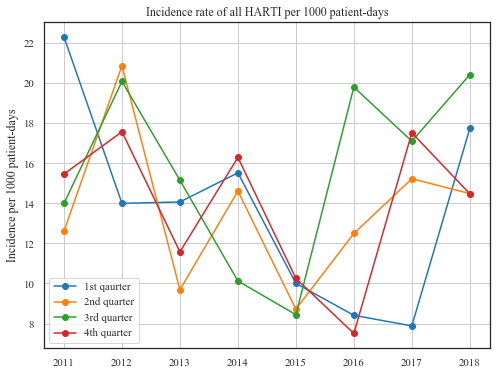

In [31]:
# All HARTI cases per quarter
harti_date = vae_data_main[['ID_subid', 'ir_first_date']].groupby('ID_subid').first().values.astype('datetime64')
harti_per_day = {}
index = np.arange(min_date_per_subid.min(), max_date_per_subid.max(), datetime.timedelta(days=1))

for day in index:
    harti_per_day[day] = (day == harti_date).sum()
    
harti_per_day = pd.DataFrame(pd.Series(harti_per_day))

month_from_year = (patients_per_day.index.year - patients_per_day.index.year.min()) * 12
month_from_month = patients_per_day.index.month
patients_per_day['quarter'] = ((month_from_month + month_from_year) // 3).astype('int')
harti_per_day['quarter'] = ((month_from_month + month_from_year) // 3).astype('int')

quarter_inc = {}
ci_dict = {}
for i in range(4):
    quarter_inc[i] = (harti_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
    cil, cir = ci(harti_per_day.groupby('quarter').sum()[i::4][0].sum(), patients_per_day.groupby('quarter').sum()[i::4][0].sum())
    ci_dict[i] = [cil*1000, cir*1000]
df = pd.DataFrame.from_dict(quarter_inc)
df = df.head(32)

fig, ax = plt.subplots(figsize=(8,6))
for col in df.columns:
    plot_data = df[col].dropna()
    ax.plot(plot_data.values, linewidth=1.5, label=col, marker='o')
ax.legend(['1st qaurter', '2nd quarter', '3rd quarter', '4th quarter'])
ax.grid('dotted')
ax.set_ylabel('Incidence per 1000 patient-days')
xlabels = ('', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
ax.set_xticklabels(xlabels)
ax.set_title('Incidence rate of all HARTI per 1000 patient-days')
plt.savefig('./pictures/inc_rate_quarters.pdf', dpi=600)
  

In [32]:
print('Average incidence per quarter:\n', df.mean())
print('\nSTD per quarter:\n', df.std())
avg = (df.mean()[0] + df.mean()[1] + df.mean()[3])/3
print('Average per quarters 1, 2 and 4: ', avg)
print('% of change: ', df.mean()[2]*100 / avg -100)
print('\nCI for avg incidence: ', pd.DataFrame.from_dict(ci_dict))

Average incidence per quarter:
 0    13.747184
1    13.594125
2    15.649044
3    13.839017
dtype: float64

STD per quarter:
 0    4.924885
1    3.759181
2    4.592712
3    3.682194
dtype: float64
Average per quarters 1, 2 and 4:  13.726775084533498
% of change:  14.003790454776663

CI for avg incidence:             0          1          2          3
0  11.006419  11.266025  13.330129  11.862431
1  15.287596  15.334960  17.544396  16.098931


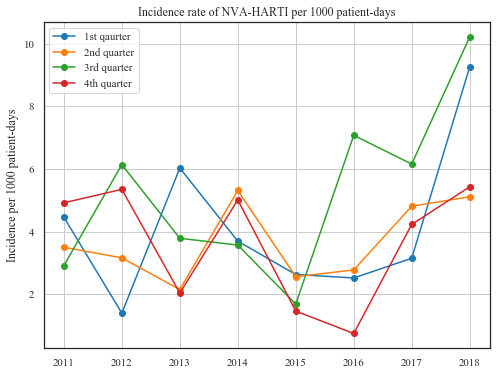

In [33]:
# Select group data for VA- and NVA-HARTI

vals = None
vals = vae_data_main[['ID_subid', 'vap', 'infection_respiratory']].groupby('ID_subid').max()

vap = vals[vals.vap > 0].index
non_vap_resp_hai = vals.loc[(vals.vap == 0) & (vals.infection_respiratory > 0)].index

data_vap = vae_data_main[vae_data_main.ID_subid.isin(vap)]
data_non_vap_resp_hai = vae_data_main[vae_data_main.ID_subid.isin(non_vap_resp_hai)]

dsets = {'vap': data_vap, 
         'non_vap_resp_hai': data_non_vap_resp_hai, 
        }

# NVA-HARTI cases per quarter
nva_date = dsets['non_vap_resp_hai'][['ID_subid', 'ir_first_date']].groupby('ID_subid').first().values.astype('datetime64')

nva_per_day = {}
index = np.arange(min_date_per_subid.min(), max_date_per_subid.max(), datetime.timedelta(days=1))

for day in index:
    nva_per_day[day] = (day == nva_date).sum()
    
nva_per_day = pd.DataFrame(pd.Series(nva_per_day))
nva_per_day['quarter'] = ((month_from_month + month_from_year) // 3).astype('int')

quarter_inc = {}
ci_dict = {}
for i in range(4):
    quarter_inc[i] = (nva_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
    cil, cir = ci(nva_per_day.groupby('quarter').sum()[i::4][0].sum(), patients_per_day.groupby('quarter').sum()[i::4][0].sum())
    ci_dict[i] = [cil*1000, cir*1000]
df = pd.DataFrame.from_dict(quarter_inc)
df = df.head(32)

fig, ax = plt.subplots(figsize=(8,6))
for col in df.columns:
    plot_data = df[col].dropna()
    ax.plot(plot_data.values, linewidth=1.5, label=col, marker='o')
    ax.legend(['1st qaurter', '2nd quarter', '3rd quarter', '4th quarter'])
    ax.grid('dotted')
    ax.set_ylabel('Incidence per 1000 patient-days')
    xlabels = ('', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
    ax.set_xticklabels(xlabels)
    ax.set_title('Incidence rate of NVA-HARTI per 1000 patient-days')
    plt.savefig('./pictures/inc_rate_quarters_nva.pdf', dpi=600)

In [34]:
print('Average incidence per quarter:\n', df.mean())
print('\nSTD per quarter:\n', df.std())
avg = (df.mean()[0] + df.mean()[1] + df.mean()[3])/3
print('Average per quarters 1, 2 and 4: ', avg)
print('% of change: ', df.mean()[2]*100 / avg -100)
r = (2.523129 + 2.777778 + 0.750188) / 3
print('Average 2016: ', r)
print ('Difference 3rd quarter vs others, 2016: ', 7.077141 / r)
print('\nCI for avg incidence: ', pd.DataFrame.from_dict(ci_dict))

Average incidence per quarter:
 0    4.145335
1    3.675674
2    5.195748
3    3.651582
dtype: float64

STD per quarter:
 0    2.491504
1    1.236532
2    2.743566
3    1.914451
dtype: float64
Average per quarters 1, 2 and 4:  3.824197175704413
% of change:  35.86507123744576
Average 2016:  2.0170316666666666
Difference 3rd quarter vs others, 2016:  3.508691071615964

CI for avg incidence:            0         1         2         3
0  2.852385  2.477041  3.811193  2.628650
1  5.238081  4.583714  6.226830  4.827713


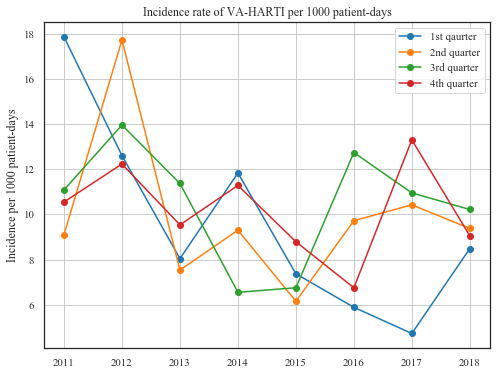

In [35]:
# VA-HARTI cases per quarter
va_date = dsets['vap'][['ID_subid', 'ir_first_date']].groupby('ID_subid').first().values.astype('datetime64')
va_per_day = {}
index = np.arange(min_date_per_subid.min(), max_date_per_subid.max(), datetime.timedelta(days=1))

for day in index:
    va_per_day[day] = (day == va_date).sum()
    
va_per_day = pd.DataFrame(pd.Series(va_per_day))
va_per_day['quarter'] = ((month_from_month + month_from_year) // 3).astype('int')

quarter_inc = {}
for i in range(4):
    quarter_inc[i] = (va_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
df = pd.DataFrame.from_dict(quarter_inc)
df = df.head(32)

fig, ax = plt.subplots(figsize=(8,6))
for col in df.columns:
    plot_data = df[col].dropna()
    ax.plot(plot_data.values, linewidth=1.5, label=col, marker='o')
    ax.legend(['1st qaurter', '2nd quarter', '3rd quarter', '4th quarter'])
    ax.grid('dotted')
    ax.set_ylabel('Incidence per 1000 patient-days')
    xlabels = ('', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018')
    ax.set_xticklabels(xlabels)
    ax.set_title('Incidence rate of VA-HARTI per 1000 patient-days')
    plt.savefig('./pictures/inc_rate_quarters_va.pdf', dpi=600)

In [36]:
print('Average incidence per quarter:\n', df.mean())
print('\nSTD per quarter:\n', df.std())
avg = (df.mean()[0] + df.mean()[1] + df.mean()[3])/3
print('Average per quarters 1, 2 and 4: ', avg)
print('% of change: ', df.mean()[2]*100 / avg -100)

Average incidence per quarter:
 0     9.601849
1     9.918450
2    10.453296
3    10.187435
dtype: float64

STD per quarter:
 0    4.281966
1    3.430156
2    2.617813
3    2.093446
dtype: float64
Average per quarters 1, 2 and 4:  9.902577908829086
% of change:  5.561357686656208


In [37]:
d = df[0].dropna()

# Fit linear regression for NVA-HARTI incidence
# Define data
x = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
x = sm.add_constant(x)
y = d.values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     9.914
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0198
Time:                        09:43:00   Log-Likelihood:                -18.551
No. Observations:                   8   AIC:                             41.10
Df Residuals:                       6   BIC:                             41.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2789.1267    882.762      3.160      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


# HARTI rate per patient-days

HARTI per 1000 pts-days, Adfuller test:  0.00022289599628217704


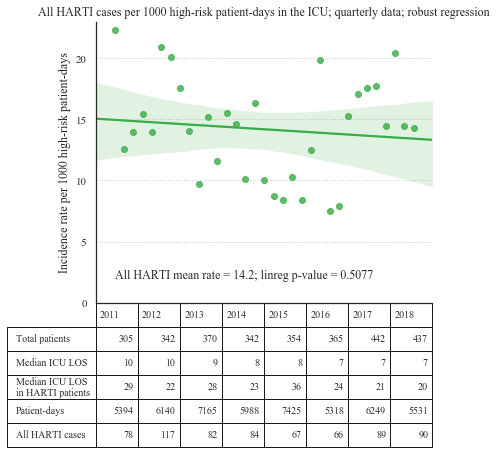

In [38]:
# Prepare long dataset for incidence of all HARTI
inc_all = []
for i in range(4):
    a = (harti_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
    inc_all.append(a)
inc_all = pd.DataFrame(inc_all)
inc_all = inc_all.T.apply(lambda x: (x.dropna()), axis=1)
inc_all['quarter'] = inc_all.index
inc_all_long = pd.melt(inc_all, id_vars='quarter')

# Prepare data for a table
all_pts = vae_data_main[['ID_subid', 'year']].groupby('ID_subid').max()
all_pts = pd.DataFrame(all_pts.year.value_counts()).sort_index()
los = vae_data_main[['ID_subid', 'year', 'day_in_icu_max']].groupby('ID_subid').max()
los = los.groupby('year').median().astype('int')
los_harti = vae_data_main[['ID_subid', 'year', 'day_in_icu_max', 'infection_respiratory']].groupby('ID_subid').max()
los_harti = los_harti[los_harti.infection_respiratory == True].groupby('year').median().astype('int')
los_harti = los_harti['day_in_icu_max']
# TODO: цифры пациенто-дней не сходятся с посчитанными выше
pts_days = vae_data_main[['ID_subid', 'year', 'day_in_icu_max']].groupby('ID_subid').max()
pts_days = pts_days.groupby('year').sum().astype('int')
all_cases = vae_data_main[['ID_subid', 'year', 'infection_respiratory']].groupby('ID_subid').max()
all_cases = all_cases.groupby('year').sum().astype('int')
table = pd.concat([all_pts, los, los_harti, pts_days, all_cases], axis=1).T
table.index = (['Total patients', 'Median ICU LOS', 'Median ICU LOS\nin HARTI patients',
                'Patient-days', 'All HARTI cases'])
colors_sns = ['medium green']
sns.set_palette(sns.xkcd_palette(colors_sns))
# Fit a robust regression
seaborn_grid = sns.lmplot(x='quarter', y='value', data=inc_all_long, robust=True)
seaborn_grid.fig.set_figwidth(6)
plt.grid(linestyle='dotted')
plt.ylabel("Incidence rate per 1000 high-risk patient-days")
plt.xlabel("")
plt.xticks([], [])
plt.ylim(0, 23)
plt.title("All HARTI cases per 1000 high-risk patient-days in the ICU; quarterly data; robust regression")
sns.set_palette("tab10")

# Plot table
plot_table = plt.table(cellText=table.values, cellLoc='right',
                  rowLabels=table.index, rowLoc='left', colLoc='left', colLabels=table.columns)
plot_table.auto_set_font_size(False)
plot_table.set_fontsize(10)
plot_table.scale(1, 2)

# Get p-value from linear regression
x = inc_all_long.quarter.values
x = sm.add_constant(x)
y = inc_all_long.value.values
results = sm.OLS(y, x).fit()
pval = results.pvalues[1]
text = np.round(inc_all_long.value.mean(), 1)
plt.text(0, 2, 'All HARTI mean rate = '+ "%.1f" % text + '; linreg p-value = '+ "%.4f" % pval, fontsize=12)

plt.savefig('./pictures/incidence_days.pdf', bbox_inches="tight", dpi=600)

# Adfuller test for stationarity
print('HARTI per 1000 pts-days, Adfuller test: ', adfuller(inc_all_long.value.values)[1])

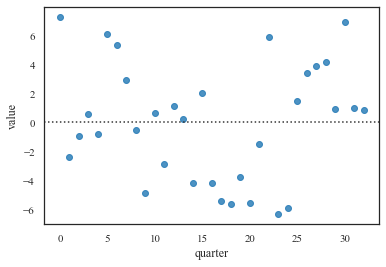

In [39]:
# plot residuals
sns.residplot(x='quarter', y='value', data=inc_all_long)
####### uniform distribution of residuals -> can use linear model

In [40]:
# Show full linear regression results table for incidence rate
# Define data
x = inc_all_long.quarter.values
x = sm.add_constant(x)
y = inc_all_long.value.values

# Fit OLS model
#model = sm.NegativeBinomial(y, x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.4492
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.508
Time:                        09:43:07   Log-Likelihood:                -92.512
No. Observations:                  33   AIC:                             189.0
Df Residuals:                      31   BIC:                             192.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0173      1.402     10.710      0.0

# VA- and NVA-HARTI rates per patient-days

In [41]:
# Prepare long dataset for incidence of all HARTI
inc_vap = []
for i in range(4):
    a = (va_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
    inc_vap.append(a)
inc_vap = pd.DataFrame(inc_vap)
inc_vap = inc_vap.T.apply(lambda x: (x.dropna()), axis=1)

inc_nva = []
for i in range(4):
    a = (nva_per_day.groupby('quarter').sum()[i::4][0] / patients_per_day.groupby('quarter').sum()[i::4][0]*1000)
    inc_nva.append(a)
inc_nva = pd.DataFrame(inc_nva)
inc_nva = inc_nva.T.apply(lambda x: (x.dropna()), axis=1)

VA-HARTI per 1000 pts-days, Adfuller test:  7.40429272099473e-05
NVA-HARTI per 1000 pts-days, Adfuller test:  0.014026339846911587


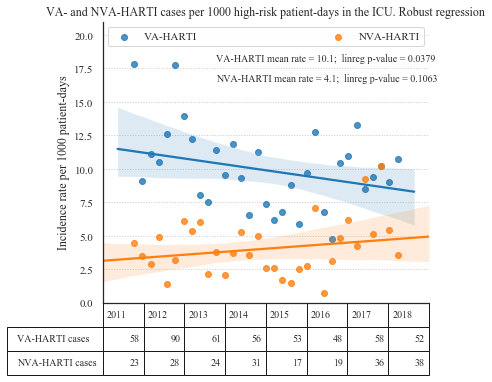

In [42]:
## VA- and NVA-HARTI

# Prepare long dataset
inc = pd.concat([inc_vap, inc_nva], axis=1)
inc.columns = ('VA-HARTI', 'NVA-HARTI')
inc['quarter'] = inc_vap.index
inc_long = pd.melt(inc, id_vars='quarter')

# Prepare data for a table
vap_cases = vae_data_main[['ID_subid', 'year', 'vap']].groupby('ID_subid').max()
vap_cases = vap_cases.groupby('year').sum().astype('int')
nva_cases = vae_data_main[['ID_subid', 'year', 'non_vap_resp_hai']].groupby('ID_subid').max()
nva_cases = nva_cases.groupby('year').sum().astype('int')
table = pd.concat([vap_cases, nva_cases], axis=1).T
table.index = (['VA-HARTI cases', 'NVA-HARTI cases'])

# fit linear regression
seaborn_grid = sns.lmplot(x='quarter', y='value', hue="variable", data=inc_long, robust=True, legend=False)
seaborn_grid.fig.set_figwidth(6)
plt.grid(linestyle='dotted')
plt.ylabel("Incidence rate per 1000 patient-days")
plt.xlabel("")
plt.xticks([], [])
plt.ylim(0, 21)
plt.title("VA- and NVA-HARTI cases per 1000 high-risk patient-days in the ICU. Robust regression")
plt.legend(ncol=2, mode="expand")

# Get p-value from linear regression, VA-HARTI
x = inc.quarter.values
x = sm.add_constant(x)
y = inc['VA-HARTI'].values
results_va = sm.OLS(y, x).fit()
pval_va = results_va.pvalues[1]
text_va = inc['VA-HARTI'].mean()
plt.text(10, 18, 'VA-HARTI mean rate = '+ "%.1f" % text_va + ';  linreg p-value = '+ "%.4f" % pval_va, fontsize=10)

# Get p-value from linear regression, NVA-HARTI
x = inc.quarter.values
x = sm.add_constant(x)
y = inc['NVA-HARTI'].values
results_nva = sm.OLS(y, x).fit()
pval_nva = results_nva.pvalues[1]
text_nva = inc['NVA-HARTI'].mean()
plt.text(10, 16.5, 'NVA-HARTI mean rate = '+ "%.1f" % text_nva + ';  linreg p-value = '+ "%.4f" % pval_nva, fontsize=10)

# Plot table
plot_table = plt.table(cellText=table.values, cellLoc='right',
                  rowLabels=table.index, rowLoc='left', colLoc='left', colLabels=table.columns)
plot_table.auto_set_font_size(False)
plot_table.set_fontsize(10)
plot_table.scale(1, 2)
plt.savefig('./pictures/incidence_days_VA_NVA.pdf', bbox_inches="tight", dpi=600)

# Adfuller test for stationarity
print('VA-HARTI per 1000 pts-days, Adfuller test: ', adfuller(inc['VA-HARTI'])[1])
print('NVA-HARTI per 1000 pts-days, Adfuller test: ', adfuller(inc['NVA-HARTI'])[1])

In [43]:
print('Incidence rate VA-HARTI 2011: ', inc_vap.head(4).mean())
print('Incidence rate VA-HARTI 2018: ',inc_vap.tail(4).mean())

Incidence rate VA-HARTI 2011:  0    12.150217
dtype: float64
Incidence rate VA-HARTI 2018:  0    9.84061
dtype: float64


In [44]:
# Fit linear regression for incidence rate for VA-HARTI
# Define data
x = inc.quarter.values
x = sm.add_constant(x)
y = inc['VA-HARTI'].values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     4.702
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0379
Time:                        09:43:19   Log-Likelihood:                -80.525
No. Observations:                  33   AIC:                             165.0
Df Residuals:                      31   BIC:                             168.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8778      0.975     12.181      0.0

In [45]:
# Fit linear regression for incidence rate of NVA-HARTI
# Define data
x = inc.quarter.values
x = sm.add_constant(x)
y = inc['NVA-HARTI'].values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.766
Date:                Fri, 21 Aug 2020   Prob (F-statistic):              0.106
Time:                        09:43:19   Log-Likelihood:                -69.881
No. Observations:                  33   AIC:                             143.8
Df Residuals:                      31   BIC:                             146.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1395      0.706      4.445      0.0

# VA-HARTI rates per ventilator-days

In [46]:
# Prepare data
# a/b
# a numerator
ir_first_dates = vae_data_main.loc[vae_data_main.vap == 1, ['ID_subid', 'ir_first_date']].groupby('ID_subid').first()
quarters = ((ir_first_dates.ir_first_date.dt.year - ir_first_dates.ir_first_date.dt.year.min()) * 12 + ir_first_dates.ir_first_date.dt.month) // 3
quarters = quarters.astype(int)
numer = ir_first_dates.groupby(quarters).count()

# b denominator
quarters = ((vae_data_main.date.dt.year - vae_data_main.date.dt.year.min()) * 12 + vae_data_main.date.dt.month) // 3
quarters = quarters.astype(int)
denom = vae_data_main[['mech_vent']].groupby(quarters).sum()

case_per_ventilator_days = (pd.DataFrame(numer.to_numpy().reshape(-1) / denom.to_numpy().reshape(-1)) * 1000)

# Prepare long dataset
case_per_ventilator_days['quarter'] = case_per_ventilator_days.index
inc_vap_long = pd.melt(case_per_ventilator_days, id_vars='quarter')

VA-HARTI per 1000 vent-days, Adfuller test:  0.006511100347264487


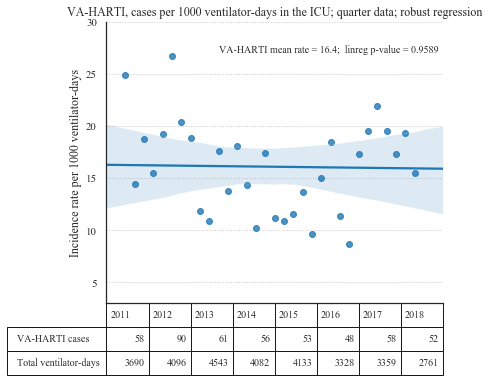

In [47]:
# Plot incidence rate

# Prepare data for a table
vap_cases = vae_data_main[['ID_subid', 'year', 'vap']].groupby('ID_subid').max()
vap_cases = vap_cases.groupby('year').sum().astype('int')
mech_vent_days = vae_data_main[['ID_subid', 'year', 'mech_vent']]
mech_vent_days = mech_vent_days.groupby('year').sum().astype('int')
table = pd.concat([vap_cases, mech_vent_days], axis=1).T
table.index = (['VA-HARTI cases', 'Total ventilator-days'])

# fit a nonparametric regression using a lowess smoother
seaborn_grid = sns.lmplot(x='quarter', y='value', data=inc_vap_long, robust=True)
seaborn_grid.fig.set_figwidth(6)
plt.grid(linestyle='dotted')
plt.ylabel("Incidence rate per 1000 ventilator-days")
plt.xlabel("")
plt.xticks([], [])
plt.title("VA-HARTI, cases per 1000 ventilator-days in the ICU; quarter data; robust regression")
plt.ylim(3, 30)

# Get p-value from linear regression, VA-HARTI
x = case_per_ventilator_days.quarter.values
x = sm.add_constant(x)
y = case_per_ventilator_days[0].values
results = sm.OLS(y, x).fit()
pval = results.pvalues[1]
text = case_per_ventilator_days[0].mean()
plt.text(10, 27, 'VA-HARTI mean rate = '+ "%.1f" % text + ';  linreg p-value = '+ "%.4f" % pval, fontsize=10)

# Plot table
plot_table = plt.table(cellText=table.values, cellLoc='right',
                  rowLabels=table.index, rowLoc='left', colLoc='left', colLabels=table.columns)
plot_table.auto_set_font_size(False)
plot_table.set_fontsize(10)
plot_table.scale(1, 2)
plt.savefig('./pictures/incidence_vent-days.pdf', bbox_inches="tight", dpi=600)

print('VA-HARTI per 1000 vent-days, Adfuller test: ', adfuller(inc_vap_long['value'])[1])

In [48]:
# Test changes in ventilator-days
x = mech_vent_days.index.values
x = sm.add_constant(x)
y = mech_vent_days.mech_vent.values

# Fit OLS model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     5.712
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0540
Time:                        09:43:23   Log-Likelihood:                -58.983
No. Observations:                   8   AIC:                             122.0
Df Residuals:                       6   BIC:                             122.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.343e+05   1.38e+05      2.417      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


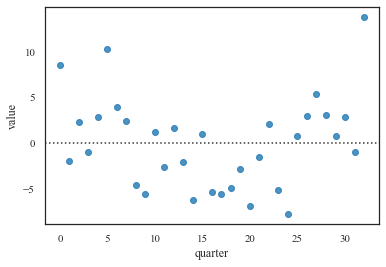

In [49]:
# plot residuals
sns.residplot(x='quarter', y='value', data=inc_vap_long)
####### uniform distribution of residuals -> can use linear model

_____